# Project: Read The Text

**Description:** A blurry image was received and appropriate methods for image deblurring were found. The strengths and limitations of the different methods were analyzed. Blurring is a source of image degradation in many applications e.g., medical imaging, microscopy, space observations, and feature recognition.
<br/>

**Goal:** Apply deconvolution techniques on the target image to an extent were information concealed by blur and noise can be read. 

## Import Libraries

In [1]:
from functions import *
import matplotlib.pyplot as plt
%matplotlib inline

## Load Target Image

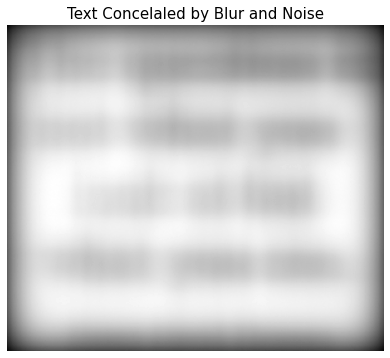

In [2]:
data = sc.loadmat("matrices.mat")
Ar = data.get("Ar")
Ac = data.get("Ac")
B = data.get("B")

plt.figure(figsize=(10,6))
plt.title('Text Concelaled by Blur and Noise', fontsize=15)
plt.axis('off')
plt.imshow(B, cmap = 'gray')

## The Blurr Model
<br/>
<div style="text-align: justify">  
Two of the most important and ubiquitous sources of image degradation are noise and blur.
Blur is the spatial redistribution of image intensities. When redistribution follows the same spatial pattern at all image location, the blurred image $f$ can modelled by the convolution of the original sharp object $g$ with a blurring spatially-invariant medium called blur kernel or point spread function (PSF) $h$, in addition to a random additive noise $n$ : 
<br/>
<br/>
\begin{equation}
    f=g*h+n
\end{equation}
<br/>
Methods that aim at a computational (approximate) inversion of the blur process are called deconvolution.
    </div>

### The Point Spread Function (PSF)
<br/>
<div style="text-align: justify">  
The point spread function (PSF) is a description of the degree to which an image is blurred (spread) and characterizes the response of an imaging system to a point source or point object.
<br/>
    </div>

In [3]:
psf = create_psf(B, Ar, Ac)

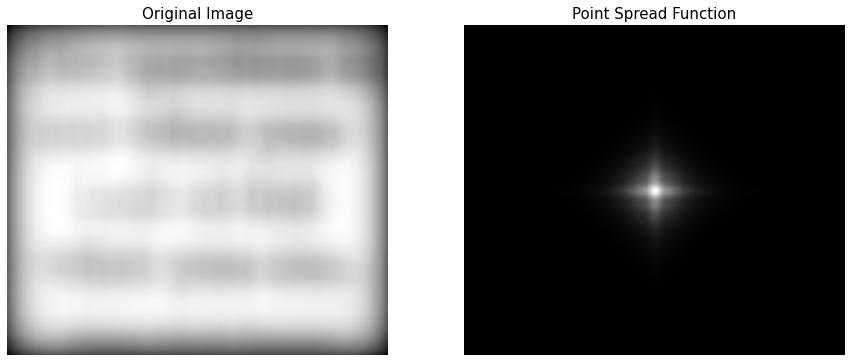

In [4]:
compare_2_imgs (B,psf, title1 = 'Original Image', title2 = 'Point Spread Function')

## Solution / Deconvolution 

### The Naïve Inverse Solution
<br/>
<div style="text-align: justify">  
In order to recover a sharp image from the observed blurred one, several methods were tackled in literature.
We start with basic naive inverse filter by first assuming that the noise can be neglected thus the blur model is reduced to $f=g*h$.
We apply then the Fourier Transform to simply the computation $\hat{f}=\hat{g}*\hat{h}$. One can simplify observe that 
<br/>
<br/>
\begin{equation}
    \hat{u}=\frac{\hat{f}}{\hat{h}}
\end{equation}
<br/>
If $\hat{h}$ is known, then we can easily compute $\hat{u}$ to recover the original image $g$ or an approximation of it $u$.
However, in most cases $\hat{h}$ possesses zeroes which represent frequencies which are deleted by blurring with $h$ and must not be present in a noise-free blurring process. $|\hat{h}|$ is still very small in the vicinity of its zeroes which yields tremendous noise amplification rendering the procedure extremely unstable.
<br/>   
    </div>

In [5]:
deblurred_inverse = inverse_filter(B, psf)

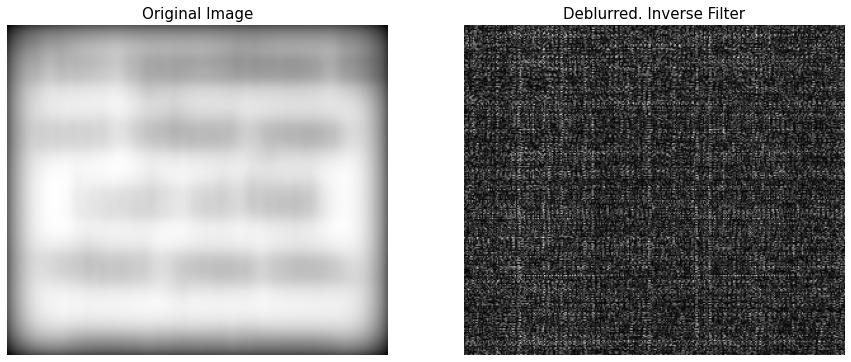

In [6]:
compare_2_imgs (B, deblurred_inverse, title1 = 'Original Image', title2 = 'Deblurred. Inverse Filter')

### Wiener Filter
<br/>
<div style="text-align: justify"> 
An advanced regularization technique of inverse filtering that handles these limitations is Wiener Filter
<br/>
<br/>
\begin{equation}
    \hat{u} = \frac{1}{|\hat{h}|}. \frac{|\hat{h}|^2}{|\hat{h}|^2 + H^2}. \hat{f}
\end{equation}
<br/>
where $H$ is the inverse of $\mathrm{SNR}$. Wiener filter displays better stability than the inverse filtering. It has properties of a band-pass and is therefore even well-suited to deal with moderate noise. 
<br/>   
    </div>

In [7]:
deblurred_wiener = wiener_filter(B, psf, 20000)

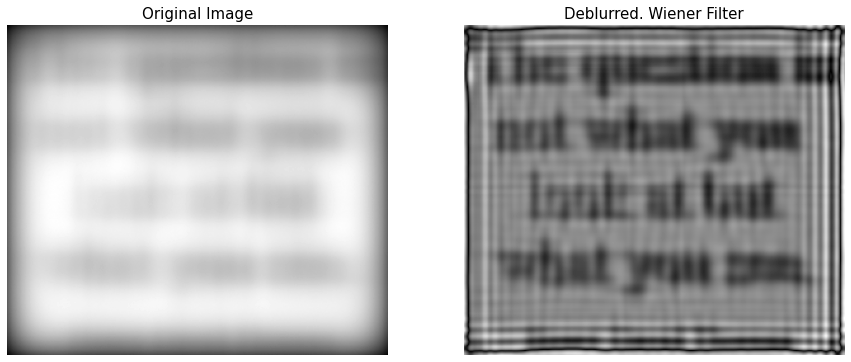

In [8]:
compare_2_imgs (B, deblurred_wiener, title1 = 'Original Image', title2 = 'Deblurred. Wiener Filter')

### Tikhonov Filter


#### Well-Posedness

Jacques Hadamard ($20^{th}$ century) french mathematician conjectured that mathematical models that describe physical phenomena should verify the following conditions:

   - The solution must exist.
   - The solution must be unique.
   - The map from data to solutions is continuous in some topology.
    
Problems that are not well-posed in the sense of Hadamard are called ill-posed problems. Deblurring an image is in fact an ill-posed problem e.g the inverse problem or the least-square approach which makes it very sensitive to noise.

\begin{equation}
    E(u) = \int \left | u*h -f \right |^2
\end{equation}

Discretization of the integral equation with respect to the input data $f$ and solution $u$, results in a linear algebraic system $Au=f$ (Wing, 1991; Hansen, 1998), thus the solution of this least-squares problem is given by the system of normal equations

\begin{equation}
    A^T Au=A^T f
\end{equation}

The matrix $A$ is ill-conditioned, so the solution $u$is unstable with respect to variations of the input data $f$.
Tikhonov theorem brings up the necessity of the use of a priori knowledge about the sought-for results in trying to solve an ill-posed problem.

It consists of qualitative and quantitative additive information about the original object. However, this is built on the general availability  of a compact set. Phillips (1962) proposed a variational method that relies on choosing the smoothest approximation out of the solutions set.

Subsequently, Tikhonov (1963) proposed a more general variational method based on the idea of stablising an energy functional. The variational deconvolution problem is then described as the minimization of the following energy functional

\begin{equation}
    E(u) = \int \left | u*h -f \right |^2 + \alpha \int \Psi (| \nabla u| ^2)
\end{equation}
\begin{equation}
    E(u) = \left | | Au -f | \right|^2_{\mathrm{R^m}} + \alpha \left|| Lu | \right |^2_{\mathrm{R^m}}
\end{equation}

The first summand in the energy functional is the data-term usually referring to the the square error that penalises deviation from the noise-free blur model $f=u*h$, the second integral is a regularisation term which encourages smoothness of the sought image and in some cases keeping the edges intacts or even sharpen them.
Thus, the solution of the minimization problem is given by the linear algebraic system,

\begin{equation}
    A^T Au + \alpha L^T Lu=A^T f
\end{equation}

The discrete zeroth-order Tikhonov regularization corresponding to when the penalizing functional $\Psi$ is quadratic or $L= I_n$ (L: $\Psi$ matrix, $n$ matrix order ), takes the form

\begin{equation}
    E(u) = \int \left | u*h -f \right |^2 + \alpha \int | \nabla u| ^2
\end{equation}

or 

\begin{equation}
    (A^T A + \alpha I_n ) u =A^T f
\end{equation}

It is interesting to experiment with the SVD matrix of $A$ where

\begin{equation}
   A= U \Sigma V^T= \sum_{i=1}^n u_i \sigma_i v_i^T
\end{equation}

where $U$ and $V$ are orthogonal matrices and $\Sigma$ is a rectangular diagonal matrix of eigenvalues of the matrix $A$.
Consequently, the application of singular value decomposition on the matrix $A$ yields the following solution

\begin{equation}
\begin{aligned}
 u =(A^T A + \alpha I_n ) ^{-1} A^T f= (V \Sigma^T U^T U \Sigma V^T+ \alpha I_n )^{-1} V \Sigma^T U^T f \\
      = (V (\Sigma^T \Sigma V^T +  \alpha I_n) V^T)^{-1} \Sigma^T U^T f= \sum_{1}^{n} c_i \frac{u_i . f }{\sigma_i} v_i
\end{aligned}
\end{equation}

where $c_i = \frac{\sigma_i^2}{\sigma_i^2+ \alpha}$ .


In [9]:
deblurred_tikhonov = tikhonov(B, Ar, Ac, 0.002)

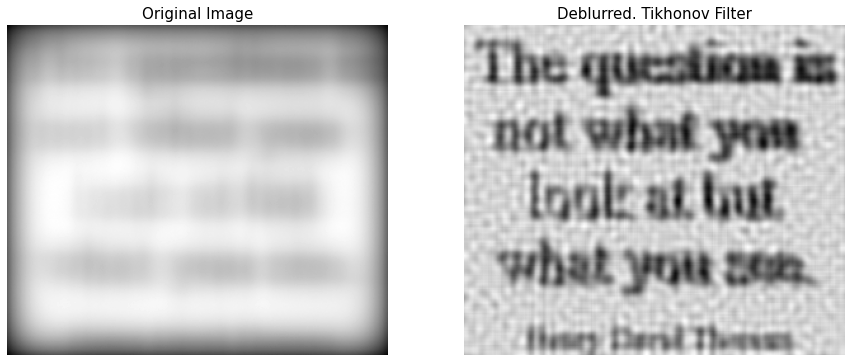

In [10]:
compare_2_imgs (B, deblurred_tikhonov, title1 = 'Original Image', title2 = 'Deblurred. Tikhonov Filter')

## Post-Processing
<br/>
<div style="text-align: justify"> 
Post-processing was utilized in the resulting image after Tikhonov filtering. This step is expected to enhance the filtered image. The following post-processing steps were applied:

    
  - **Sharpening**. A convolution with a 2D sharpening filter was applied (value of postition[1,1] in sharpening filter = 5).
  - **Thresholding**. Background/ noise removal. 
  - **Constrast enhancement**. CLAHE (contrast limited Adaptive histogram equalization). Used to improve contrast in the image with a limited amplification to reduce the problem of noise amplification.
<br/>   
    </div>

In [11]:
deblurred_tikhonov = normalize_uint8(deblurred_tikhonov)
deblurred_tikhonov_PP = postprocess(deblurred_tikhonov)

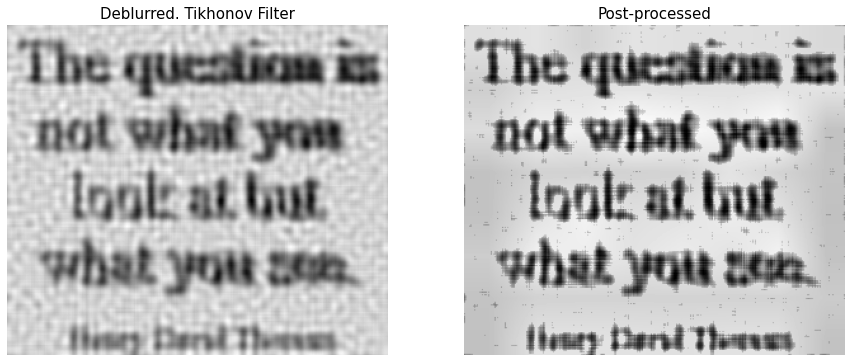

In [12]:
compare_2_imgs (deblurred_tikhonov, deblurred_tikhonov_PP, title1 = 'Deblurred. Tikhonov Filter', title2 = 'Post-processed')

## References

*  N. Wiener. Extrapolation, Interpolation and Smoothing of Stationary Time Series with Engineering Applications. Cambridge (Mass.), 1949, The MIT Press

* M. Bertero and P. Boccacci. Introduction to Inverse Problems in Imaging. IoP Publishing, Bristol, 1998.

* M. Bertero, T. A. Poggio, and V. Torre. Ill-posed problems in early vision. Pro- ceedings of the IEEE, 76(8):869–889, Aug. 1988.

* Tikhonov, A. N., On the stability of inverse problems. Dokl. Akad. Nauk SSSR, vol. 39, no. 5, pp. 195â€“198, 1943 (in Russian).

* Tikhonov, A. N., Solution of incorrectly formulated problems and the regularization method, Dokl. Akad. Nauk SSSR, vol. 151, no. 3, pp. 501â€“504 (in Russian); English transl.: Soviet Math. Dokl., vol. 4, no. 4, pp. 1035â€“1038, 1963a.

* Tikhonov, A. N., Regularization of incorrectly posed problems, Dokl. Akad. Nauk SSSR, vol. 153, no. 1, pp. 49â€“52 (in Russian); English transl.: Soviet Math. Dokl., vol. 4, no. 6, pp. 1624â€“1627, 1963b.

* Tikhonov, A. N. and Arsenin, V. Y., Solution of Ill-Posed Problems, Wiley, Hoboken, NJ, 1977.

* Picture Thresholding using an iterative selection method. (1978). IEEE Transactions on Systems, Man, and Cybernetics, 8(8), 630–632. https://doi.org/10.1109/tsmc.1978.4310039 

* Basics of image Deblurring - Emory University. (n.d.). Retrieved July 14, 2022, from http://www.mathcs.emory.edu/~nagy/courses/fall06/ID_lecture1.pdf 

* Sankhe, P. D., Patil, M., &amp; Margaret, M. (2011). Deblurring of grayscale images using inverse and Wiener filter. Proceedings of the International Conference &amp; Workshop on Emerging Trends in Technology - ICWET '11. https://doi.org/10.1145/1980022.1980053 

* Yadav, G., Maheshwari, S., &amp; Agarwal, A. (2014). Contrast Limited adaptive histogram equalization based enhancement for Real Time Video System. 2014 International Conference on Advances in Computing, Communications and Informatics (ICACCI). https://doi.org/10.1109/icacci.2014.6968381 